In [1]:
import cv2
import numpy as np
import pandas as pd
import pickle
import xgboost as xgb
from matplotlib import pyplot as plt
import skimage
import os
import sys
from time import time
sys.path.append(os.environ['REPO_DIR'])
from extractPatches import patch_extractor
from lib.utils import configuration, run
from matplotlib.path import Path
from shapely.geometry import Polygon

In [4]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
def features_extractor(patch,state,params,extractor):
    tile=patch
    contours, _ = cv2.findContours(tile.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if state=='positive':
        if len(contours)==1:
            object_area = cv2.contourArea(contours[0])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            object_area = max(areas)
    else:
        if len(contours)==2:
            object_area = cv2.contourArea(contours[0])-cv2.contourArea(contours[1])
        else:
            areas=[]
            for j in range(len(contours)):
                areas.extend([cv2.contourArea(contours[j])])
            areas=np.sort(areas)
            object_area = areas[-1]-areas[-2]

    if params['preprocessing']['polarity']==-1:
        tile = 255-tile
    min_std=params['preprocessing']['min_std']
    _std = np.std(tile.flatten())

    extracted = []
    if _std < min_std:
        extracted.append([0] * 201)
    else:
        Stats = extractor.segment_cells(tile)
        cells = extractor.extract_blobs(Stats,tile)
        cells = pd.DataFrame(cells)
        cells = cells[cells['padded_patch'].notnull()]
        cells = cells.drop(['padded_patch','left','top'],1)
        cells = np.asarray(cells)
        for k in range(len(cells)):
            cells[k][0] = cells[k][0][:10]
        origin = np.concatenate((np.array(list(cells[:,0])),cells[:,1:]),axis=1)
        for k in range(origin.shape[1]):
            x, y = CDF(origin[:,k])
            ten = [x[np.argmin(np.absolute(y-0.1*(j+1)))] for j in range(10)]
            extracted.extend(ten)
        extracted.extend([cells.shape[0]/object_area*224*224/100])
    return extracted

In [5]:
stack = 'MD594'
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')

#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.2      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'binary:logistic' #'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=1
num_round = 100

yamlfile=os.environ['REPO_DIR']+'shape_params.yaml'
params=configuration(yamlfile).getParams()

cell_dir = os.environ['ROOT_DIR'] + 'CSHL_patches_features/MD589/'
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
features_fn = 'CSHL_region_features/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)
features_fn = features_fn+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+features_fn):
    os.mkdir(os.environ['ROOT_DIR']+features_fn)

savepath = 'CSHL_shift/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)
savepath = savepath+stack+'/'
if not os.path.exists(os.environ['ROOT_DIR']+savepath):
    os.mkdir(os.environ['ROOT_DIR']+savepath)

resol = 0.46
step_size = 22


ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))


In [5]:
%%time
section = 137
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape
margin = 200/0.46
extractor = patch_extractor(params)

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

ALREADY DOWNLOADED FILE
CPU times: user 751 ms, sys: 650 ms, total: 1.4 s
Wall time: 1.83 s


In [48]:
%%time
t1 =time()
grid_fn = features_fn + str(section) + '.pkl'
grid_features = {}
count = 0
Scores = {}
for contour_id, contour in polygons:
    structure = contour_id
    if structure not in all_structures:
        continue
    polygon = contour.copy()
    Scores[structure] = {}

    if structure == '7n':
        structure = '7nn'

    fp = []
    fp.append(cell_dir + structure + '/MD589_' + structure + '_positive.pkl')
    fp.append(cell_dir + structure + '/MD589_' + structure + '_negative.pkl')
    features = []
    labels = []
    for state in range(2):
        clouds = pickle.load(open(fp[state], 'rb'))
        features.extend(np.array(clouds))
        labels.extend([1 - state] * len(clouds))
    features = np.array(features)
    labels = np.array(labels)
    X_train = features
    y_train = labels
    dtrain = xgb.DMatrix(X_train, label=y_train)
    bst = xgb.train(param, dtrain, num_round, verbose_eval=False)

    if structure == '7nn':
        structure = '7n'

    [left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 0]) + margin), n - 1)),
                               int(max(min(polygon[:, 1]) - margin, 0)),
                               int(min(np.ceil(max(polygon[:, 1]) + margin), m - 1))]
    xs, ys = np.meshgrid(np.arange(left, right + 1), np.arange(up, down + 1), indexing='xy')
    locations = np.c_[xs.flat, ys.flat]

    path = Path(polygon)
    indices_inside = np.where(path.contains_points(locations))[0]
    indices_in = locations[indices_inside]
    x_raw = indices_in[:, 0] - left
    y_raw = indices_in[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_in)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section)+'_positive'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10,11):
        try:
            nleft = int(max(left+i*step_size, 0))
            nright = int(min(right+i*step_size, n-1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:,int(nleft -left-i*step_size):\
                                                         int(nleft -left-i*step_size)+nright - nleft + 1]
            
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('x'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_x_'+str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch,'positive',params,extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up+i*step_size, 0))
            ndown = int(min(down+i*step_size, n-1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup -up-i*step_size):\
                                                         int(nup -up-i*step_size)+ndown - nup + 1, :]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('y'+str(i))

            grid_index = str(section) + '_' + structure + '_' + 'postive_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'positive', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section)+'_positive']['x'] = x_shift
    Scores[structure][str(section)+'_positive']['y'] = y_shift


    surround = Polygon(polygon).buffer(margin, resolution=2)
    path = Path(list(surround.exterior.coords))

    indices_sur = np.where(path.contains_points(locations))[0]
    indices_outside = np.setdiff1d(indices_sur, indices_inside)
    indices_out = locations[indices_outside]
    x_raw = indices_out[:, 0] - left
    y_raw = indices_out[:, 1] - up
    mask = np.zeros((down - up + 1, right - left + 1))
    for i in range(len(indices_out)):
        mask[y_raw[i], x_raw[i]] = 1
    mask = mask.astype(np.uint8)

    Scores[structure][str(section) + '_negative'] = {}
    x_shift = []
    y_shift = []
    for i in range(-10, 11):
        try:
            nleft = int(max(left + i * step_size, 0))
            nright = int(min(right + i * step_size, n - 1))
            patch = img[up:down + 1, nleft:nright + 1] * mask[:, int(nleft - left - i * step_size): \
                                                            int(nleft - left - i * step_size) + nright - nleft + 1]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('x'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_x_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            x_shift.extend([score])
        except:
            x_shift.extend([0])

        try:
            nup = int(max(up + i * step_size, 0))
            ndown = int(min(down + i * step_size, n - 1))
            patch = img[nup:ndown + 1, left:right + 1] * mask[int(nup - up - i * step_size): \
                                                              int(nup - up - i * step_size) + ndown - nup + 1, :]
#             plt.figure()
#             plt.imshow( patch, cmap='gray')
#             plt.title('y'+str(i))
            grid_index = str(section) + '_' + structure + '_' + 'negative_y_' + str(i)
            if grid_index in grid_features.keys():
                extracted = grid_features[grid_index]
            else:
                extracted = features_extractor(patch, 'negative', params, extractor)
                grid_features[grid_index] = extracted

            xtest = xgb.DMatrix(extracted)
            score = bst.predict(xtest, output_margin=True, ntree_limit=bst.best_ntree_limit)
            y_shift.extend([score])
        except:
            y_shift.extend([0])

    Scores[structure][str(section) + '_negative']['x'] = x_shift
    Scores[structure][str(section) + '_negative']['y'] = y_shift

    count += 1
    print(section, structure, count, '/', len(polygons))

pickle.dump(grid_features, open(os.environ['ROOT_DIR'] + grid_fn, 'wb'))
setup_upload_from_s3(grid_fn, recursive=False)
filename = savepath + str(section)+ '.pkl'
pickle.dump(Scores, open(os.environ['ROOT_DIR'] + filename, 'wb'))
setup_upload_from_s3(filename, recursive=False)
os.remove(os.environ['ROOT_DIR']+img_fn)
print(str(section) + ' finished in %5.1f seconds' % (time() - t1))

138 IC 1 / 10
138 Sp5C 2 / 10
138 DC 3 / 10
138 SNR 4 / 10
138 Sp5O 5 / 10
138 VLL 6 / 10
138 SC 7 / 10
138 PBG 8 / 10
138 Sp5I 9 / 10
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_region_features/MD594/138.pkl s3://mousebrainatlas-data/CSHL_region_features/MD594/138.pkl
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/138.pkl s3://mousebrainatlas-data/CSHL_shift/MD594/138.pkl
138 finished in 2315.7 seconds
CPU times: user 1h 10min 31s, sys: 5min 3s, total: 1h 15min 35s
Wall time: 38min 35s


In [76]:
section = 163
grid_fn = features_fn + str(section) + '.pkl'
filename = savepath + str(section)+ '.pkl'
setup_upload_from_s3(grid_fn, recursive=False)
setup_upload_from_s3(filename, recursive=False)

run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_region_features/MD594/163.pkl s3://mousebrainatlas-data/CSHL_region_features/MD594/163.pkl
run cmd= aws s3 cp /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/163.pkl s3://mousebrainatlas-data/CSHL_shift/MD594/163.pkl


In [16]:
section =94
filename = savepath + str(section)+ '.pkl'
setup_download_from_s3(filename, recursive=False)
scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))

run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_shift/MD594/94.pkl /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_shift/MD594/94.pkl


In [17]:
scores.keys()

dict_keys(['VCA'])

In [18]:
scores

{'VCA': {'94_positive': {'x': [array([-4.0781918], dtype=float32),
    array([-4.3690877], dtype=float32),
    array([-3.3695161], dtype=float32),
    array([-5.30971], dtype=float32),
    array([-3.3932755], dtype=float32),
    array([-2.5561578], dtype=float32),
    array([-1.4512378], dtype=float32),
    array([0.09695113], dtype=float32),
    array([0.51189893], dtype=float32),
    array([2.012927], dtype=float32),
    array([0.35825568], dtype=float32),
    array([-0.23671122], dtype=float32),
    array([-1.7154372], dtype=float32),
    array([-2.453755], dtype=float32),
    array([-3.4338655], dtype=float32),
    array([-4.621012], dtype=float32),
    array([-4.981338], dtype=float32),
    array([-4.054709], dtype=float32),
    array([-3.8744702], dtype=float32),
    array([-2.1588223], dtype=float32),
    array([-3.1113863], dtype=float32)],
   'y': [array([-5.2077746], dtype=float32),
    array([-6.3060756], dtype=float32),
    array([-4.7393904], dtype=float32),
    array([-4.

In [79]:
V=[x[0] for x in scores['7n'][str(section)+'_positive']['x']]

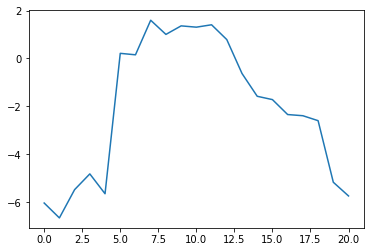

In [80]:
#%pylab inline
plot(V)

In [21]:
script_dir = os.environ['REPO_DIR']
! python $script_dir/Shape_shift.py 'MD594' 112 'shape_params.yaml'

/Users/kuiqian/Github/venv/shapeology_venv/lib/python3.7/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE
/Users/kuiqian/Github/shapeology_code/scripts/lib/utils.py:22: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.D=yaml.load(open(yamlFile,'r'))
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_prep2_lossless_gray.tif
download: s3://mousebrainatlas-data/CSHL_data_processed

download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_lossless_gray.tif to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_prep2_lossless_gray.tif
run cmd= aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif
download: s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif to ../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD594/MD594_prep2_lossless_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_prep2_lossless_gray.tif
run cmd= aws s3 cp s3:

In [41]:
contours_struc = contours.groupby('name')

In [57]:
seq = sort(contours_struc.get_group('VCA')['section'].unique())
seq[np.argmax(seq[2:]-seq[:-2])+1]

124

In [81]:
current_structures = []
for structure in paired_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    if seq[np.argmax(seq[2:]-seq[:-2])+1]<150:
        current_structures.append(structure)
for structure in singular_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    if max(seq)<146:
        current_structures.append(structure)

In [82]:
current_structures

['PBG', 'VCA', 'VCP']

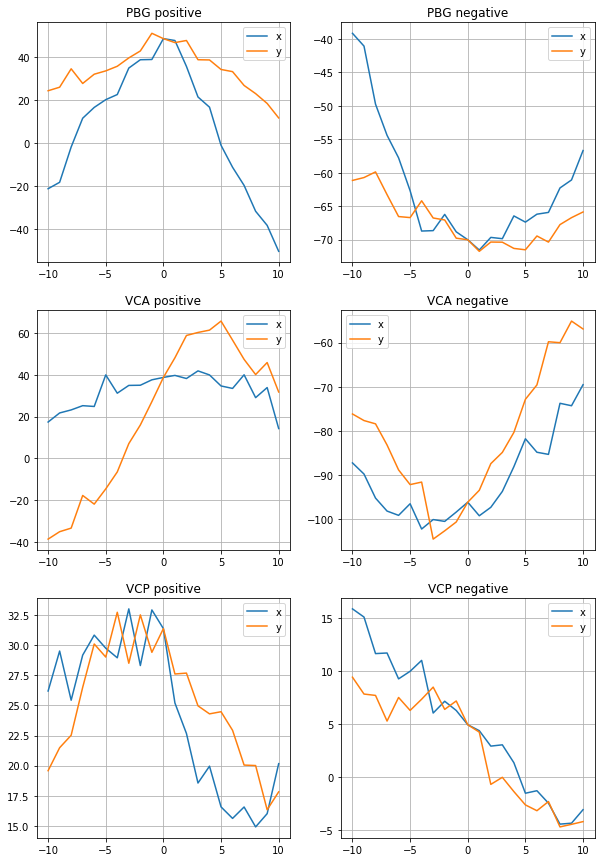

In [88]:
i = 0
figure(figsize=(10,15))
for structure in current_structures:
    seq = sort(contours_struc.get_group(structure)['section'].unique())
    sections = seq[:np.argmax(seq[2:]-seq[:-2])+2]
    for state in ['positive','negative']:
        x_shift = []
        y_shift = []
        for section in sections:
            filename = savepath + str(section)+ '.pkl'
            #setup_download_from_s3(filename, recursive=False)
            scores = pickle.load(open(os.environ['ROOT_DIR']+filename,'rb'))
            x_score=[x[0] for x in scores[structure][str(section)+'_'+state]['x']]
            x_shift.append(x_score)
            y_score=[x[0] for x in scores[structure][str(section)+'_'+state]['y']]
            y_shift.append(y_score)
        x_shift=np.array(x_shift)
        x_final = x_shift.sum(axis=0)
        y_shift=np.array(y_shift)
        y_final = y_shift.sum(axis=0)
        #figure()
        i +=1
        subplot(3,2,i)
        plot(range(-10,11), x_final, label='x')
        plot(range(-10,11), y_final, label='y')
        legend()
        grid(True)
        title(structure+' '+state)